In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import csv
from IPython.display import display
import concurrent.futures
# =========================== 1. 定义反应物 ===========================
# 此处依然可以通过CSV读取数据，格式为(描述, SMILES)，例如：
import csv
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from IPython.display import display

def load_reactants_from_csv(filename):
    """
    从CSV文件中读取反应物数据。
    CSV文件要求：
      - 第一列为描述（例如 "aldehydes_linker_1"）
      - 第二列为对应的 SMILES 字符串
    返回一个列表，每个元素为 (smiles, description) 的元组。
    """
    reactants = []
    with open(filename, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        # 如果CSV文件有标题行，则先跳过
        headers = next(reader, None)
        for row in reader:
            # 如果行数据不足两列则跳过
            if len(row) < 2:
                continue
            description = row[0].strip()
            smiles = row[1].strip()
            reactants.append((smiles, description))
    return reactants

# 分别从CSV中读取三类反应物数据
amines = load_reactants_from_csv('Van-3CR_head.csv')
isocyanides = load_reactants_from_csv('Van-3CR_linker.csv')
aldehydes = load_reactants_from_csv('Van-3CR_tail.csv')

# 打印读取的内容
print("Amines:")
for smiles, desc in amines:
    print(f"{desc}: {smiles}")

print("\isocyanides:")
for smiles, desc in isocyanides:
    print(f"{desc}: {smiles}")

print("\naldehydes:")
for smiles, desc in aldehydes:
    print(f"{desc}: {smiles}")



Amines:
A1: CCN(CC)CCN
A2: CCN(CC)CCCN
A3: NCCN(CCO)CCO
A4: NCCCN(CCO)CCO
A5: CN(C)CCCN
A6: NCCN1CCCCC1
A7: CN1CCN(CCN)CC1
A8: NCCC1=CNC2=C1C=CC=C2
A9: NCCC1=CC=CC=C1
\isocyanides:
C1: CC1=CC=C(S(=O)(=O)C([N+]#[C-])C2=CC=CC=C2C)C=C1
C2: CC1=CC=C(S(=O)(=O)C([N+]#[C-])C2=CC3=C(C=CC=C3)C=C2)C=C1
C3: CC1=CC=C(S(=O)(=O)C([N+]#[C-])C2=CC=CC=C2)C=C1
C4: COC1=CC(C([N+]#[C-])S(=O)(=O)C2=CC=C(C)C=C2)=CC=C1
C5: CC1=CC=C(S(=O)(=O)C([N+]#[C-])C2=CC=CC(Cl)=C2)C=C1
C6: CC1=CC=C(S(=O)(=O)C([N+]#[C-])C2=CC=C(F)C(F)=C2)C=C1
C7: CC1=CC=C(S(=O)(=O)C([N+]#[C-])C2=CC(F)=CC=C2)C=C1
C8: CC1=CC=C(S(=O)(=O)C([N+]#[C-])C2=CC=C(F)C=C2)C=C1

aldehydes:
B1: CCCCCCCCOC1=CC=C(C=O)C=C1OCCCCCCCC
B2: CCCCCCCCCCOC1=CC=C(C=O)C=C1OCCCCCCCCCC
B3: CCCCCCCCCCCCOC1=CC=C(C=O)C=C1OCCCCCCCCCCCC
B4: CCCCCCCCCCCCCCOC1=CC=C(C=O)C=C1OCCCCCCCCCCCCCC
B5: CCCCCCCCOC(=O)CCCCCOC1=CC=C(C=O)C=C1OCCCCCC(=O)OCCCCCCCC
B6: CCCCCCCCCCOC(=O)CCCCCOC1=CC=C(C=O)C=C1OCCCCCC(=O)OCCCCCCCCCC
B7: CCCCCCCCCCCCOC(=O)CCCCCOC1=CC=C(C=O)C=C1OCCCCCC(=O)OCCCCCC

In [10]:
# =========================== 5. 定义处理及保存产物的函数，大量建库时候取消可视化以及循环检查点，反正输出溢出 ===========================
def process_and_save_products(product_tuples, step_name):
    """
    处理产品：
    1) 去重 & 转 SMILES（保留产品名称）
    2) 打印 SMILES 到控制台
    3) 输出有效产物到 CSV: f"{step_name}_products.csv"
    4) （可选）在 Notebook 中显示网格图
    5) 返回去重并检查后的有效产物及其名称列表
    """
    import csv
    from rdkit import Chem
    from rdkit.Chem import Draw
    from IPython.display import display

    if not product_tuples:
        print(f"[{step_name}] 没有产物生成.")
        return [], []

    # 1) 去重（根据 SMILES 去重，同时保留名称，保留第一次出现的名称）
    unique_dict = {}
    for mol, name in product_tuples:
        smi = Chem.MolToSmiles(mol, isomericSmiles=True)
        if smi not in unique_dict:
            unique_dict[smi] = name
    unique_smiles = list(unique_dict.keys())
    print(f"[{step_name}] 原产物数: {len(product_tuples)}, 去重后: {len(unique_smiles)}")

    # 2) 在控制台打印 SMILES 列表
    print(f"[{step_name}] 产物 SMILES 列表 (去重后):")
    for smi in unique_smiles:
        print("  ", smi)

    # 3) 转回 Mol，并进行 Sanitize 检查，同时收集有效产品的名称
    valid_mols = []
    valid_names = []
    invalid_smiles = []
    for smi in unique_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            #print(f"[警告] 无法从 SMILES 解析: {smi}")
            invalid_smiles.append(smi)
            continue
        try:
            Chem.SanitizeMol(mol)
            valid_mols.append(mol)
            valid_names.append(unique_dict[smi])
        except Exception as e:
            print(f"[非法产物] SMILES: {smi} | 错误: {e}")
            invalid_smiles.append(smi)
    print(f"[{step_name}] Sanitize 检查后有效产物数: {len(valid_mols)}，非法产物数: {len(invalid_smiles)}")

    # 4) 保存有效产物 CSV（包括编号、名称和 SMILES）
    csv_filename = f"{step_name}_products.csv"
    with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["编号", "名称", "SMILES"])
        for idx, (mol, name) in enumerate(zip(valid_mols, valid_names), start=1):
            smi = Chem.MolToSmiles(mol, isomericSmiles=True)
            writer.writerow([idx, name, smi])
    print(f"[{step_name}] 有效产物 CSV 已保存: {csv_filename}")

    # 5) 保存非法产物 CSV（如果有）
    if invalid_smiles:
        invalid_csv_filename = f"{step_name}_invalid_products.csv"
        with open(invalid_csv_filename, "w", newline="", encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["SMILES"])
            for smi in invalid_smiles:
                writer.writerow([smi])
        print(f"[{step_name}] 非法产物 CSV 已保存: {invalid_csv_filename}")

    # 6) 在 Notebook 中显示网格图
    if valid_mols:
        img = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(200, 200))
        display(img)
        # 如需保存图片，可启用如下代码：
        # png_filename = f"{step_name}_products.png"
        # img_data = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(200, 200), returnPNG=True)
        # with open(png_filename, "wb") as f:
        #     f.write(img_data)
        # print(f"[{step_name}] 图片已保存: {png_filename}")

    return valid_mols, valid_names




In [ ]:
'''代码测试
from rdkit import Chem
from rdkit.Chem import AllChem

# =========================== 2. 定义反应 SMARTS ===========================
reaction_smarts = "[NH2:1].[CX3H:2]=O.[C-:3]#[N+:4][C:5]>>[N:1]1[C:2]-[C:5]-[N:4]=[C:3]1"
reaction = AllChem.ReactionFromSmarts(reaction_smarts)
print("反应有效性:", reaction.IsInitialized())  # 检查反应是否被正确识别

# =========================== 3. 存储产物集合 ===========================
# 这里存储的是 (产物mol, 产品编号) 的元组
product_tuples = []

# =========================== 4. 遍历反应 ===========================
for amine_smiles, amine_desc in amines:
    for aldehyde_smiles, aldehyde_desc in aldehydes:
        for isocyanide_smiles, isocyanide_desc in isocyanides:
            # 转换反应物为Mol对象
            amine = Chem.MolFromSmiles(amine_smiles)
            aldehyde = Chem.MolFromSmiles(aldehyde_smiles)
            isocyanide = Chem.MolFromSmiles(isocyanide_smiles)
            
            if None in (amine, aldehyde, isocyanide):
                print(f"[警告] 无效反应物: {amine_desc}, {aldehyde_desc}, {isocyanide_desc}")
                continue

            # 执行反应
            products = reaction.RunReactants([amine, aldehyde, isocyanide])
            for product_set in products:
                for product in product_set:
                    try:
                        Chem.SanitizeMol(product)  # 标准化检查
                        # 生成产品编号，格式为 "Amines描述_isocyanides描述"
                        product_code = f"{amine_desc}_{isocyanide_desc}"
                        product_tuples.append((product, product_code))
                    except Chem.AtomValenceException as e:
                        print(f"[非法产物] 跳过: {Chem.MolToSmiles(product)} | 错误: {e}")

print(f"\n总产物数: {len(product_tuples)}")

# 调用处理函数进行去重、保存及显示
final_unique_products = process_and_save_products(product_tuples, "Van_3CR")
'''

反应有效性: False

总产物数: 792
[Van_3CR] 原产物数: 792, 去重后: 792
[Van_3CR] 产物 SMILES 列表 (去重后):
   CCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccccc2C)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccc3ccccc3c2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccccc2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2cccc(OC)c2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2cccc(Cl)c2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccc(F)c(F)c2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2cccc(F)c2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccc(F)cc2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCC
   CCCCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccccc2C)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCCCC
   CCCCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccc3ccccc3c2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCCCC
   CCCCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccccc2)S(=O)(=O)c2ccc(

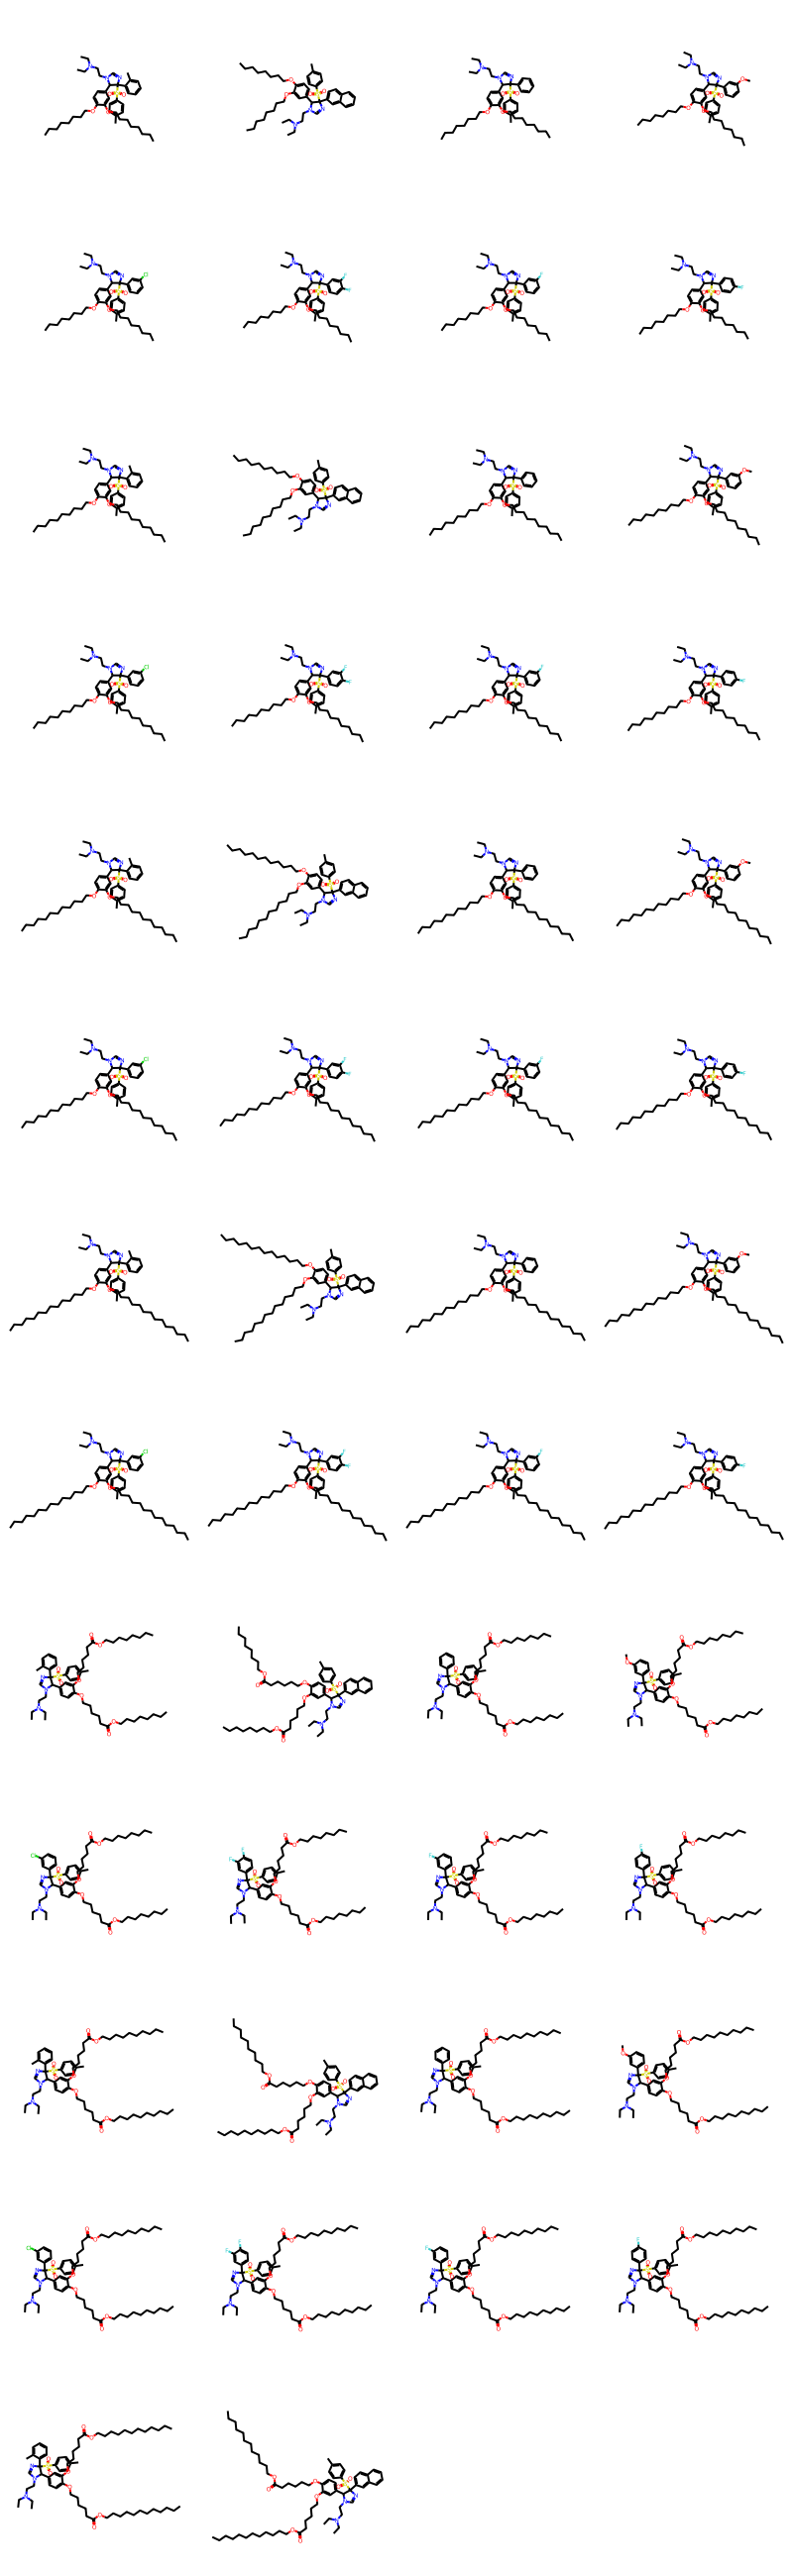

In [13]:
'''
from rdkit import Chem
from rdkit.Chem import AllChem

# =========================== 2. 定义反应 SMARTS ===========================
reaction_smarts = "[NH2:1].[CX3H:2]=O.[C-:3]#[N+:4][C:5]>>[N:1]1[C:2]-[C:5]-[N:4]=[C:3]1"
reaction = AllChem.ReactionFromSmarts(reaction_smarts)
print("反应有效性:", reaction.IsInitialized())  # 检查反应是否被正确识别

# =========================== 3. 存储产物集合 ===========================
# 这里存储的是 (产物mol, 产品编号) 的元组
product_tuples = []

# =========================== 4. 遍历反应 ===========================
for amine_smiles, amine_desc in amines:
    for aldehyde_smiles, aldehyde_desc in aldehydes:
        for isocyanide_smiles, isocyanide_desc in isocyanides:
            # 转换反应物为 Mol 对象
            amine = Chem.MolFromSmiles(amine_smiles)
            aldehyde = Chem.MolFromSmiles(aldehyde_smiles)
            isocyanide = Chem.MolFromSmiles(isocyanide_smiles)
            
            if None in (amine, aldehyde, isocyanide):
                print(f"[警告] 无效反应物: {amine_desc}, {aldehyde_desc}, {isocyanide_desc}")
                continue

            # 执行反应
            products = reaction.RunReactants([amine, aldehyde, isocyanide])
            for product_set in products:
                for product in product_set:
                    # 去除所有原子的电荷（设为中性）
                    for atom in product.GetAtoms():
                        if atom.GetFormalCharge() != 0:
                            atom.SetFormalCharge(0)
                    try:
                        Chem.SanitizeMol(product)  # 标准化检查
                        # 生成产品编号，格式为 "Amines描述_isocyanides描述"
                        product_code = f"{amine_desc}_{isocyanide_desc}"
                        product_tuples.append((product, product_code))
                    except Chem.AtomValenceException as e:
                        print(f"[非法产物] 跳过: {Chem.MolToSmiles(product)} | 错误: {e}")

print(f"\n总产物数: {len(product_tuples)}")

# 调用处理函数进行去重、保存及显示
final_unique_products = process_and_save_products(product_tuples, "Van_3CR")
'''


总产物数: 792
[Van_3CR_medit] 原产物数: 792, 去重后: 792
[Van_3CR_medit] 产物 SMILES 列表 (去重后):
   CCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccccc2C)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccc3ccccc3c2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccccc2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2cccc(OC)c2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2cccc(Cl)c2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccc(F)c(F)c2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2cccc(F)c2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccc(F)cc2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCC
   CCCCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccccc2C)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCCCC
   CCCCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccc3ccccc3c2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCCCCCC
   CCCCCCCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccccc2)S(=O)(=O)c2ccc(C

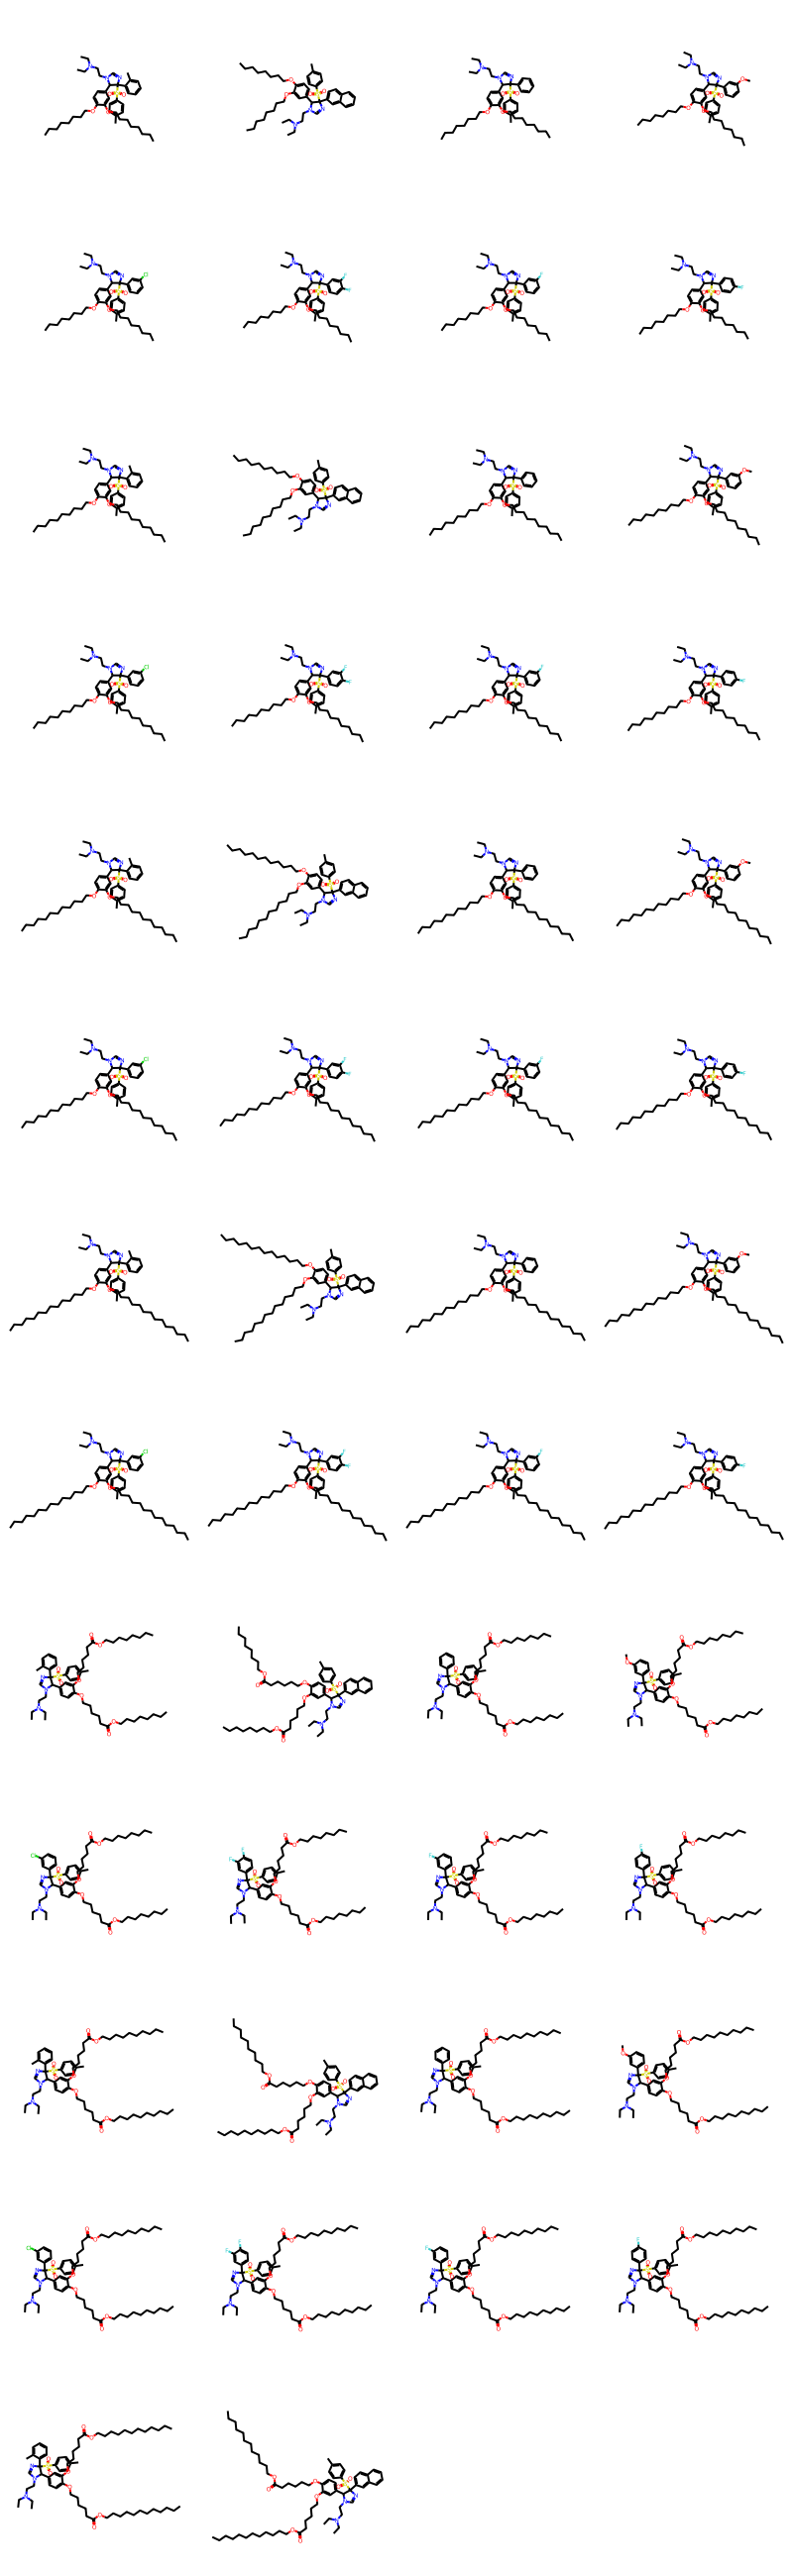

In [20]:
#多核心并行
#指定CPU数量
num_cores = 10
# 反应 SMARTS 保持不变
reaction_smarts = "[NH2:1].[CX3H:2]=O.[C-:3]#[N+:4][C:5]>>[N:1]1[C:2]-[C:5]-[N:4]=[C:3]1"

def process_combination(task):
    """
    处理单个反应物组合任务：
    输入 task 为一个六元组:
       (amine_smiles, amine_desc, aldehyde_smiles, aldehyde_desc, isocyanide_smiles, isocyanide_desc)
    返回一个列表，其中每个元素为 (产物mol, 产品编号) 的元组。
    """
    amine_smiles, amine_desc, aldehyde_smiles, aldehyde_desc, isocyanide_smiles, isocyanide_desc = task

    # 转换反应物为 Mol 对象
    amine = Chem.MolFromSmiles(amine_smiles)
    aldehyde = Chem.MolFromSmiles(aldehyde_smiles)
    isocyanide = Chem.MolFromSmiles(isocyanide_smiles)
    if None in (amine, aldehyde, isocyanide):
        # 若有无效反应物，则返回空列表
        return []

    # 为避免进程间传递问题，在每个子进程中重新创建反应对象
    reaction = AllChem.ReactionFromSmarts(reaction_smarts)
    product_list = []
    # 执行反应
    products = reaction.RunReactants([amine, aldehyde, isocyanide])
    for product_set in products:
        for product in product_set:
            # 去除所有原子的电荷（设为中性）
            for atom in product.GetAtoms():
                if atom.GetFormalCharge() != 0:
                    atom.SetFormalCharge(0)
            try:
                Chem.SanitizeMol(product)
                # 生成产品编号，格式： "Amines描述_isocyanides描述"
                product_code = f"{amine_desc}_{isocyanide_desc}"
                product_list.append((product, product_code))
            except Exception as e:
                # 若标准化失败，则跳过该产物
                # 可选：记录错误信息
                pass
    return product_list

# 构造所有任务：每个任务对应一组 (胺, 醛, 异腈) 的组合
tasks = []
for amine_smiles, amine_desc in amines:
    for aldehyde_smiles, aldehyde_desc in aldehydes:
        for isocyanide_smiles, isocyanide_desc in isocyanides:
            tasks.append((amine_smiles, amine_desc, aldehyde_smiles, aldehyde_desc, isocyanide_smiles, isocyanide_desc))

# 用户指定使用的 CPU 核心数（修改此变量即可）


# 使用 ProcessPoolExecutor 并行处理所有任务
product_tuples = []  # 用于存储 (产物mol, 产品编号) 的元组
with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
    # 使用 map 方法批量处理任务，返回的 results 为列表（每个元素都是一个列表）
    results = list(executor.map(process_combination, tasks))
    # 将所有返回结果展平
    for res in results:
        product_tuples.extend(res)

print(f"\n总产物数: {len(product_tuples)}")

# 调用处理函数进行去重、保存及显示
final_medit_products = process_and_save_products(product_tuples, "Van_3CR_medit")


断裂反应有效性: False


[13:39:00] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 7 
  unmapped numbers are: 7 
[13:39:00] mapped atoms in the reactants were not mapped in the products.
[13:39:00] mapped atoms in the reactants were not mapped in the products.
[13:39:00] mapped atoms in the reactants were not mapped in the products.
[13:39:00] mapped atoms in the reactants were not mapped in the products.
[13:39:00] mapped atoms in the reactants were not mapped in the products.
[13:39:00] mapped atoms in the reactants were not mapped in the products.
[13:39:00] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 7 
  unmapped numbers are: 7 
  unmapped numbers are: 7 
[13:39:00] mapped atoms in the reactants were not mapped in the products.
[13:39:00] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 7 
  unmapped numbers are: 7 
  unmapped numbers are: 7 
  unmapped numbers are: 7 
  unmapped number


断裂反应后总产物数: 1584
[Van3CR_final_products] 原产物数: 1584, 去重后: 792
[Van3CR_final_products] 产物 SMILES 列表 (去重后):
   CCCCCCCCOc1ccc(-c2c(-c3ccccc3C)ncn2CCN(CC)CC)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(-c2c(-c3ccc4ccccc4c3)ncn2CCN(CC)CC)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(-c2c(-c3ccccc3)ncn2CCN(CC)CC)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(-c2c(-c3cccc(OC)c3)ncn2CCN(CC)CC)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(-c2c(-c3cccc(Cl)c3)ncn2CCN(CC)CC)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(-c2c(-c3ccc(F)c(F)c3)ncn2CCN(CC)CC)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(-c2c(-c3cccc(F)c3)ncn2CCN(CC)CC)cc1OCCCCCCCC
   CCCCCCCCOc1ccc(-c2c(-c3ccc(F)cc3)ncn2CCN(CC)CC)cc1OCCCCCCCC
   CCCCCCCCCCOc1ccc(-c2c(-c3ccccc3C)ncn2CCN(CC)CC)cc1OCCCCCCCCCC
   CCCCCCCCCCOc1ccc(-c2c(-c3ccc4ccccc4c3)ncn2CCN(CC)CC)cc1OCCCCCCCCCC
   CCCCCCCCCCOc1ccc(-c2c(-c3ccccc3)ncn2CCN(CC)CC)cc1OCCCCCCCCCC
   CCCCCCCCCCOc1ccc(-c2c(-c3cccc(OC)c3)ncn2CCN(CC)CC)cc1OCCCCCCCCCC
   CCCCCCCCCCOc1ccc(-c2c(-c3cccc(Cl)c3)ncn2CCN(CC)CC)cc1OCCCCCCCCCC
   CCCCCCCCCCOc1ccc(-c2c(-c3ccc(F)c(F)c3)ncn2CCN(CC)

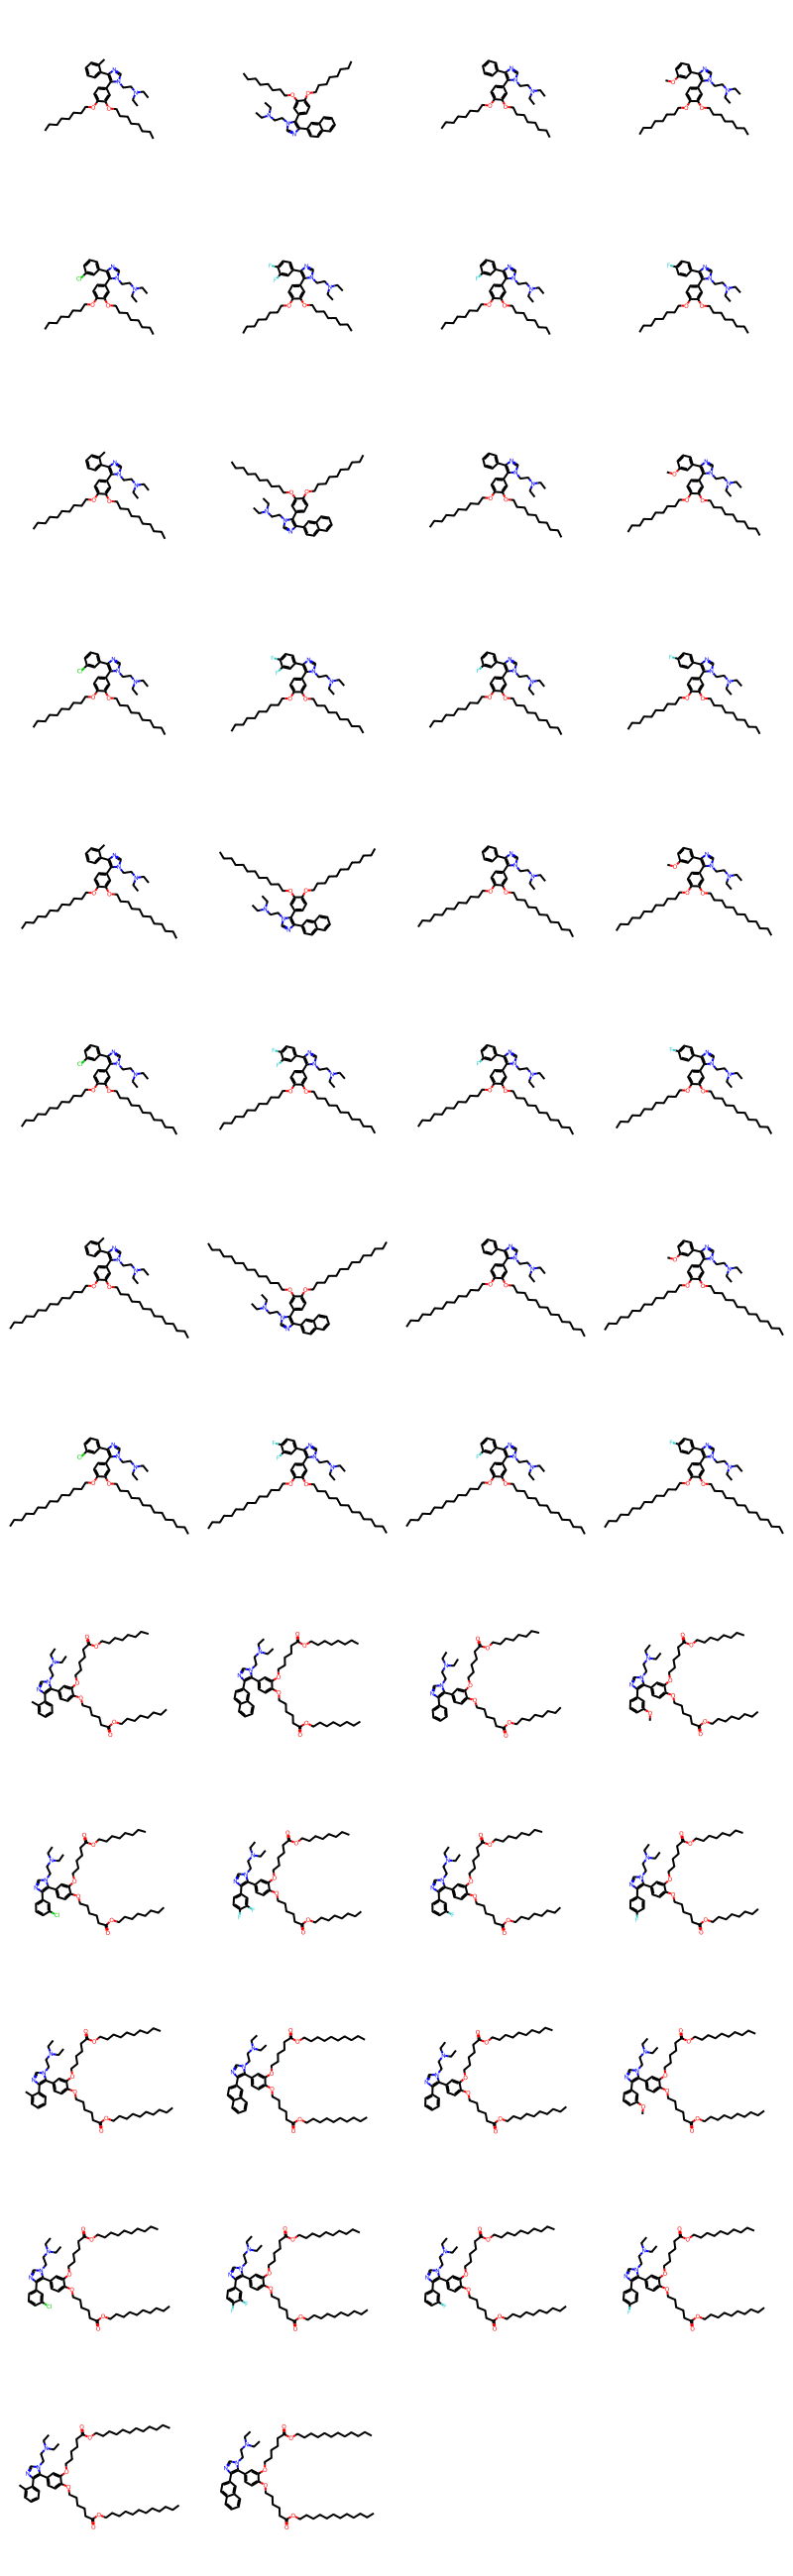

In [22]:

# 用户指定使用的 CPU 核心数（修改此变量即可）
num_cores = 10

# =========================== 1. 定义断裂反应 SMARTS ===========================
fragmentation_smarts = "[N:1]1[C:2]-[C:5](-[S:7](=O)(=O)-[*])-[N:4]=[C:3]1>>[N:1]1[C:2]=[C:5]-[N:4]=[C:3]1"
fragmentation_reaction = AllChem.ReactionFromSmarts(fragmentation_smarts)
print("断裂反应有效性:", fragmentation_reaction.IsInitialized())

# =========================== 2. 定义处理单个分子断裂反应的函数 ===========================
def process_fragmentation(task):
    """
    task 为一个二元组 (parent_mol, parent_code)
    对 parent_mol 执行断裂反应，返回一个列表，每个元素为 (产物mol, 新产品编号)
    新产品编号格式： "{parent_code}_final"
    """
    parent_mol, parent_code = task
    results = []
    if parent_mol is None:
        return results
    # 执行断裂反应
    products = fragmentation_reaction.RunReactants((parent_mol,))
    for product_set in products:
        for product in product_set:
            try:
                # 标准化检查（这里不再处理电荷，因为上一步已处理）
                Chem.SanitizeMol(product)
                # 生成产品编号，格式： "{parent_code}_final"
                product_code = f"{parent_code}_final"
                results.append((product, product_code))
            except Exception as e:
                print(f"[非法产物] 跳过: {Chem.MolToSmiles(product)} | 错误: {e}")
    return results

# =========================== 3. 并行执行断裂反应 ===========================
# 注意：这里 final_medit_products 是通过 process_and_save_products 得到的，
# 它的格式为 (valid_mols, valid_names)
# 因此我们使用 zip() 将两个列表合并，构造每个任务为 (mol, parent_code)
mols, names = final_medit_products
tasks = list(zip(mols, names))



Van_4CR_final_products = []  # 存储 (产物mol, 产品编号) 的元组
with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = list(executor.map(process_fragmentation, tasks))
    for res in results:
        Van_4CR_final_products.extend(res)

print(f"\n断裂反应后总产物数: {len(Van_4CR_final_products)}")

# =========================== 4. 保存断裂产物 ===========================
final_fragment_products = process_and_save_products(Van_4CR_final_products, "Van3CR_final")


In [23]:
ls *csv

Van-3CR_反应路线.csv                Van-3CR_linker.csv
Van3CR_final_products_products.csv  Van_3CR_medit_products.csv
Van-3CR_head.csv                    Van-3CR_tail.csv


In [29]:
import os


def process_row(row, png_folder, mol_folder):
    """
    处理单行CSV数据：生成RDKit分子，保存PNG图片和MOL文件。
    返回一个处理状态字符串。
    """
    # 获取编号、名称和SMILES（根据实际CSV标题调整）
    mol_id = row.get("编号", "").strip()
    mol_name = row.get("名称", "").strip()
    smiles = row.get("SMILES", "").strip()
    
    if not smiles:
        return "空的SMILES，跳过此行。"
    
    # 使用RDKit从SMILES生成分子
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return f"无法解析 SMILES: {smiles}，跳过。"
    
    # 尝试进行化学有效性检查
    try:
        Chem.SanitizeMol(mol)
    except Exception as e:
        return f"分子 {smiles} 清洗失败: {e}，跳过。"
    
    # 构造文件名前缀：优先使用编号和名称，例如“h1_l1_t1”
    if mol_id and mol_name:
        prefix = f"{mol_id}_{mol_name}"
    else:
        prefix = mol_id or mol_name or "molecule"
    # 清除空格和特殊字符，确保文件名安全
    prefix = "".join(c for c in prefix if c.isalnum() or c in ['-', '_'])
    if not prefix:
        prefix = "molecule"
    
    # 保存PNG图片
    png_filename = os.path.join(png_folder, f"{prefix}.png")
    try:
        Draw.MolToFile(mol, png_filename, size=(300, 300))
    except Exception as e:
        # 如有需要，可记录错误信息到日志
        pass
    
    # 保存MOL文件
    mol_filename = os.path.join(mol_folder, f"{prefix}.mol")
    try:
        Chem.MolToMolFile(mol, mol_filename)
    except Exception as e:
        # 如有需要，可记录错误信息到日志
        pass
    
    return f"处理完成: {prefix}"

def process_csv(csv_filename, num_workers=None):
    """
    读取CSV文件（包含标题行），标题至少包含："编号"、"名称"、"SMILES"。
    对每一行生成RDKit分子，并将PNG图片和MOL文件分别保存到文件夹 "png_0327" 和 "mol_0327" 中。
    使用多进程加速处理，可通过 num_workers 指定使用的CPU核心数量（默认使用所有可用核心）。
    """
    # 创建用于保存PNG和MOL文件的文件夹
    png_folder = "png_0327"
    mol_folder = "mol_0327"
    os.makedirs(png_folder, exist_ok=True)
    os.makedirs(mol_folder, exist_ok=True)
    
    # 读取CSV所有行
    with open(csv_filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        rows = list(reader)
    
    results = []
    total = len(rows)
    # 使用ProcessPoolExecutor并行处理每一行
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_row, row, png_folder, mol_folder) for row in rows]
        for i, future in enumerate(concurrent.futures.as_completed(futures), 1):
            try:
                res = future.result()
                results.append(res)
            except Exception as exc:
                results.append(f"任务异常: {exc}")
            # 每处理100行输出一次进度，避免每行打印
            if i % 1000 == 0 or i == total:
                print(f"已处理 {i}/{total} 行")
    
    # 输出最终汇总统计信息
    success = sum(1 for r in results if r.startswith("处理完成"))
    errors = total - success
    print(f"\n全部处理完成。总共处理 {total} 行，其中成功 {success} 行，错误或跳过 {errors} 行。")
    return results

# 示例调用，指定使用20个CPU核心处理
if __name__ == "__main__":
    process_csv("Van3CR_final_products_products.csv", num_workers=20)


已处理 792/792 行

全部处理完成。总共处理 792 行，其中成功 792 行，错误或跳过 0 行。


In [28]:
ls *csv

Van-3CR_反应路线.csv                Van-3CR_linker.csv
Van3CR_final_products_products.csv  Van_3CR_medit_products.csv
Van-3CR_head.csv                    Van-3CR_tail.csv
